In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm, beta, gamma
import seaborn as sns

import matplotlib.pyplot as plt
from scipy.stats import spearmanr, kendalltau

In [3]:
#%pip install copulae pycop

In [4]:
# Load libraries
import copulae

import pycop

from copulae import pseudo_obs
from copulae.archimedean import ClaytonCopula, GumbelCopula, FrankCopula
from copulae.elliptical import GaussianCopula, StudentCopula
from copulae.gof.goodness_of_fit import gof_copula
from copulas.multivariate import GaussianMultivariate



plt.rcParams["figure.figsize"] = (16, 9)  # Figure size and width

**Figure 2: Flow Chart to Use a Copula Function and Marginal CDFs of $X$ and $Y$ to Build Joint CDF of $X$ and $Y$**

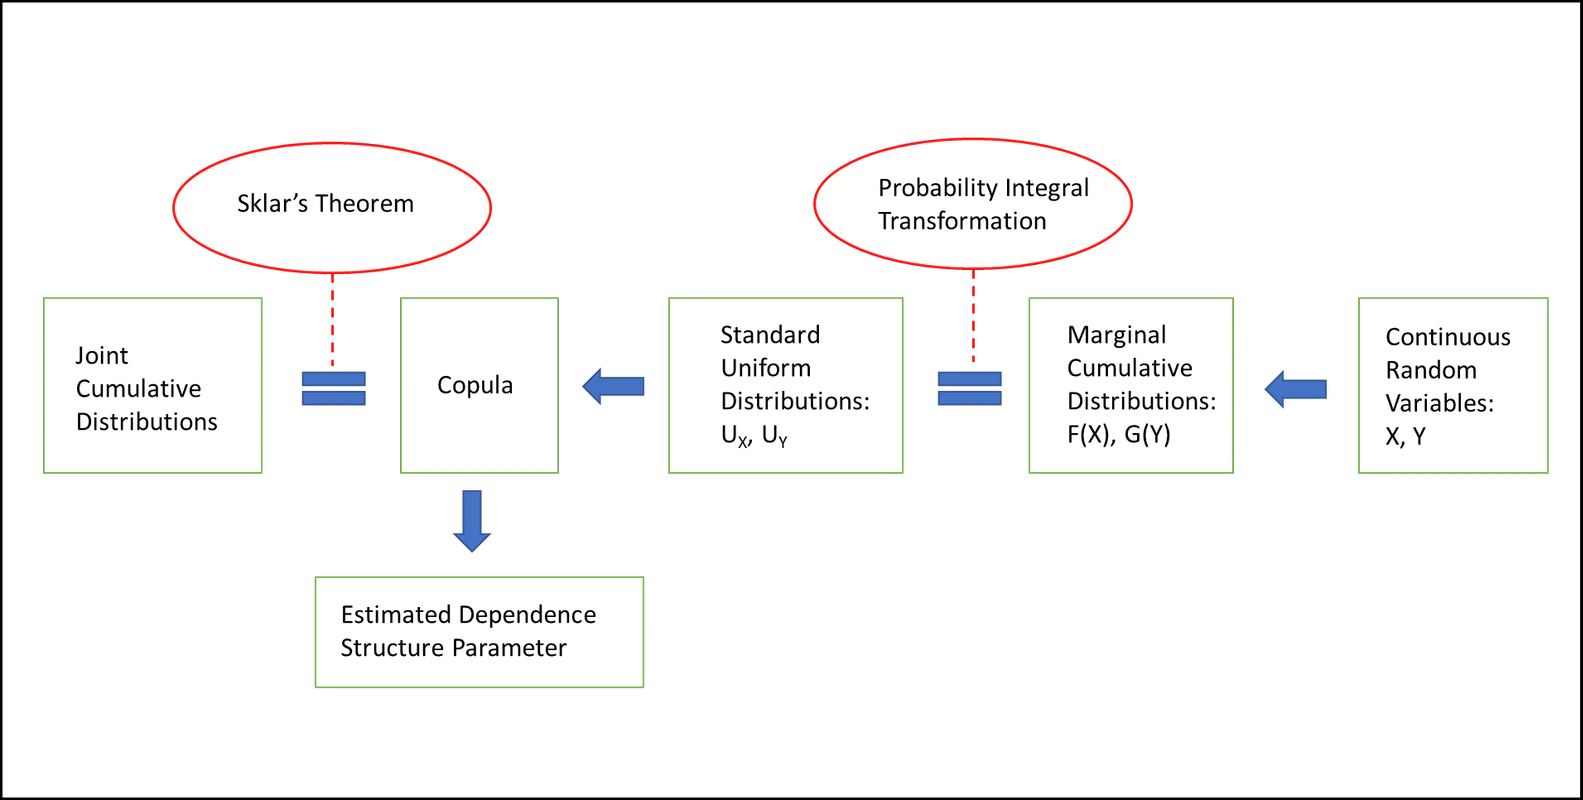


In [42]:
# Function to calculate correlation coefficient between two arrays


def corr(x, y, **kwargs):
    # Calculate the value
    coef = spearmanr(x, y)[0]
    # Make the label
    label = r"$\rho$ = " + str(round(coef, 2))

    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy=(0.3, 0.15), size=20, xycoords=ax.transAxes)

def plot(x):
    # Create the default pairplot
    grid = sns.pairplot(
        pd.DataFrame(x), height=3
    )

    # Map a scatter plot and Pearson correlation coefficient to the upper triangle
    grid = grid.map_upper(plt.scatter)
    grid = grid.map_upper(corr)

    # Map a histogram to the diagonal
    # grid = grid.map_diag(plt.hist)

    # Map a density plot and regression line to the lower triangle
    grid = grid.map_lower(sns.kdeplot)
    grid = grid.map_lower(sns.regplot, lowess=True, line_kws={"color": "red"})

# Introduction

---

L'objectif de la présent étude est d'évaluer, au moyen d'une CVAR à 99%, le risque de crédit sur un portefeuille composé de deux créances, issues du secteur bancaire, de même notionnel 1000 EUR et de même maturité 4 ans.

La première est une obligation BNP senior de taux de recouvrement de moyenne 60% et de volatilité 15%, et la seconde est une obligation Société Générale junior (ou subordonnée) de taux de recouvrement de moyenne 30% et de volatilité 25%. On suppose qu’il n’y a pas de dépendance entre les taux de recouvrement.

La perte de crédit attendue sur ce portefeuille peut s'écrire sous la forme mathématique suivante
$L= EAD_{BNP} (1 - R_{BNP}) \mathbf{1}_{\tau_{BNP} \leq 4} + EAD_{SG} (1 - R_{SG}) \mathbf{1}_{\tau_{SG} \leq 4}$ où 
- $EAD_i$ est la perte en cas de défaut. Dans notre cas elle au notionnel;
- $R_i$ est le taux de recouvrement;
- $\tau_i$ est le moment de survenu du défaut.

Nous souhaitons retrouver une CVAR à 99% qui s'écrit $CVAR_{99\%} = inf\{x, \mathbf{P}(L \leq x) \geq 99\%\}$.

Dans l'expression donnée de la perte, on note la présence de variables aléatoires (le taux de recouvrement et le moment de survenu du défaut). La caractérisation des pertes est donc conditionnée par la connaissance des distributions de ces variables.

# Extraction des probabilités de défau implicite à partir des spreads de CDS.

---

Objectif: Estimer les probabilités de défaut (PD) pour BNP et SG en utilisant les spreads des Credit Default Swap (CDS).

La PD implicite peut être approximée par la formule $PD_i (T) = \frac{S_i(T)}{1 - R}$
où $S_i(T)$ est le spread CDS de maturité T, et $R$ est le taux de recouvrement supposé pour ce spread.

On considère que les spreads de CDS de BNP et SG de maturité 4 ans sont respectivement 100bp et 120bp et ceux de maturité 5ans, 120bp et 150bp. Les CDS ont été évalués avec un taux de recouvrement égal à 40%.

In [44]:
def proba_defaut(spread, T=4, recovery = 0.4):
    lambd = spread / (1-recovery)
    return 1-np.exp(-T*lambd)

In [ ]:
# Spread de maturité 4 ans
spread_bnp = 0.01
spread_sg = 0.012

# Proba de défaut
print("Probabilités implicite extraites des spreads  de maturité 4 ans: \n") 
print("PD BNP :\t", round(proba_defaut(spread = spread_bnp),3))
print("PD SG :\t", round(proba_defaut(spread = spread_sg),3))

Probabilités implicite extraites des spreads  de maturité 4 ans: 

PD BNP :	 0.064
PD SG :	 0.077


In [110]:
# Spread de maturité 5 ans
spread_bnp = 0.012
spread_sg = 0.015

# Proba de défaut
print("Probabilités implicite extraites des spreads  de maturité 4 ans: \n") 
print("PD BNP :\t", round(proba_defaut(spread = spread_bnp),3))
print("PD SG :\t", round(proba_defaut(spread = spread_sg),3))

Probabilités implicite extraites des spreads  de maturité 4 ans: 

PD BNP :	 0.077
PD SG :	 0.095


- Pour les spreads de CDS de BNP et SG de maturité 4 ans valant respectivement 100bp et 120bp, avec un taux de recouvrement de 40%:
  BNP a une probabilité de défaut implicite de 6.4% contre 7.7% pour SG.

- Pour les spreads de CDS de BNP et SG de maturité 5ans valant respectivement 120bp et 150bp, avec un taux de recouvrement de 40%:
  BNP a une probabilité de défaut implicite de 7.7% contre 9.5% pour SG.

On remarque que la probabilité de défaut de BNP est moins élevé quie celle de SG dans chacun des scénarios. Ces probabilité de défaut sont croissantes avec la maturité des spreads.

L'obligation de BNP est de meilleure qualité d'un point de vu du risque défaut encouru. Cette observation est cohérente avec les données du problèmes qui spécifie que les obligations de BNP sont de type senior tandis que celles de SG sont de type junior.

# Carctérisation des distributions des taux de recouvrement

---
Objectif: Définir les distributions des taux de recouvrement des deux obligations.

Les taux de recouvrement, supposé indépendants, prennent des valeurs comprisent entre 0 et 1. Ils sont généralement modélisé par une loi béta. $R_i \sim \mathcal{B}eta(a_i,b_i)$ avec $a_i$ et $b_i$ entièrement déterminés par la moyenne et la volatilité.

Le taux de recouvrement de l'obligation BNP est en moyenne de 60% avec une volatilité de 15%. Pour l'obligation SG, le taux de recouvrement est en moyenne 2 fois moins élevé, avec une volatilité de 25%. La perte encourue sur une obligation SG au moment du défaut est donc en moyenne deux fois plus importante que celle d'une obligation BNP.

In [112]:
# Caractérisation des taux de recoubvrement
def recovery_rate(mu, sigma, size=100_000):
    a = mu*(mu*(1-mu)/sigma**2 - 1)
    b =(1- mu)*(mu*(1-mu)/sigma**2 - 1)
    return  np.random.beta(a,b, size=size)
    


Text(0, 0.5, 'Densit')

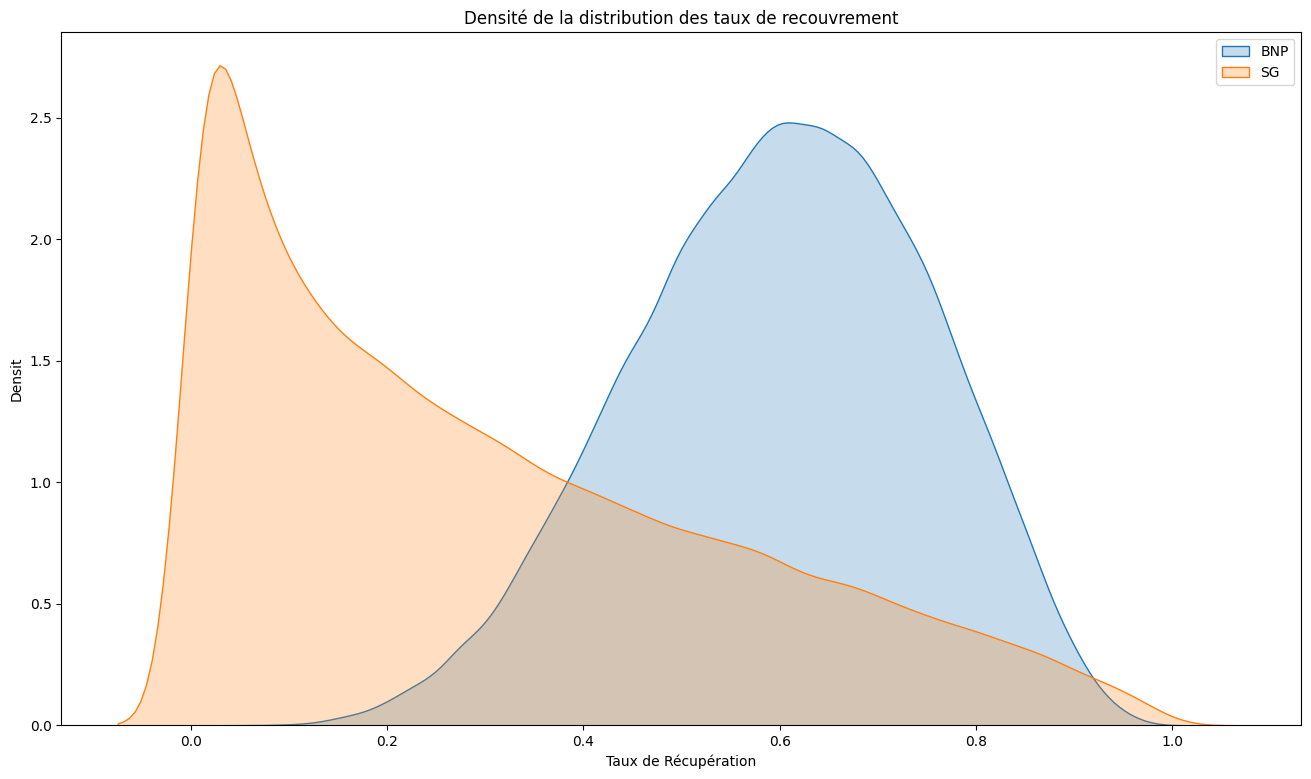

In [ ]:
# Simulation des taux de recouvrement
recovery_bnp = recovery_rate(mu = 0.6, sigma = 0.15)
recovery_sg = recovery_rate(mu = 0.3, sigma = 0.25)

# Tracer les distributions KDE
sns.kdeplot(recovery_bnp, label="BNP", shade=True)
sns.kdeplot(recovery_sg, label="SG", shade=True)

# Ajouter la légende et afficher le graphe
plt.legend()
plt.title("Densité de la distribution des taux de recouvrement")
plt.xlabel("Taux de Récupération")
plt.ylabel("Densité")

# Analyse exploration des actions BNP et SG

---
Objectif: Etudier la distibution des rendements des actions BNP et SG.

Text(0, 0.5, 'Prix')

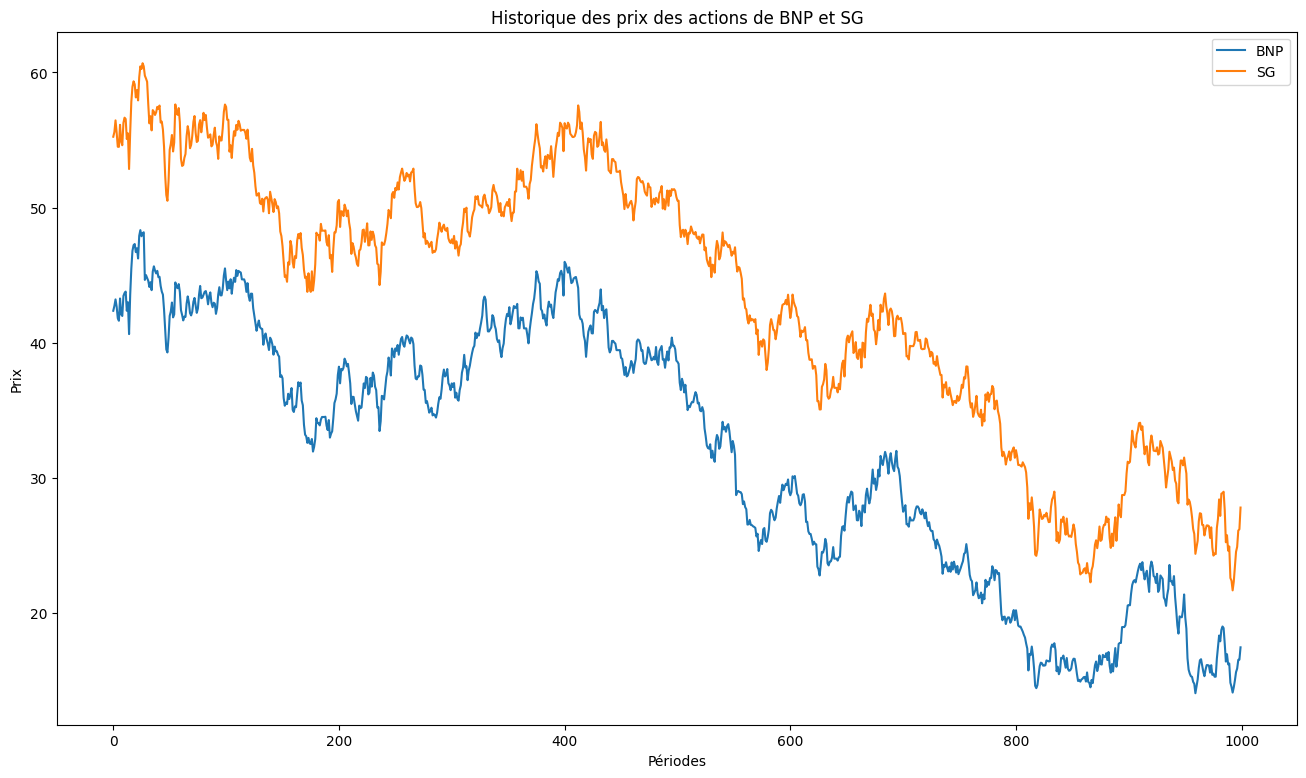

In [ ]:
# Historiques des prix des actions
stock = pd.read_csv("data.txt", sep = "\t")

stock.plot()

# Ajouter la légende et afficher le graphe
plt.legend()
plt.title("Historique des prix des actions de BNP et SG")
plt.xlabel("Périodes")
plt.ylabel("Prix")

Text(0, 0.5, 'Rendement')

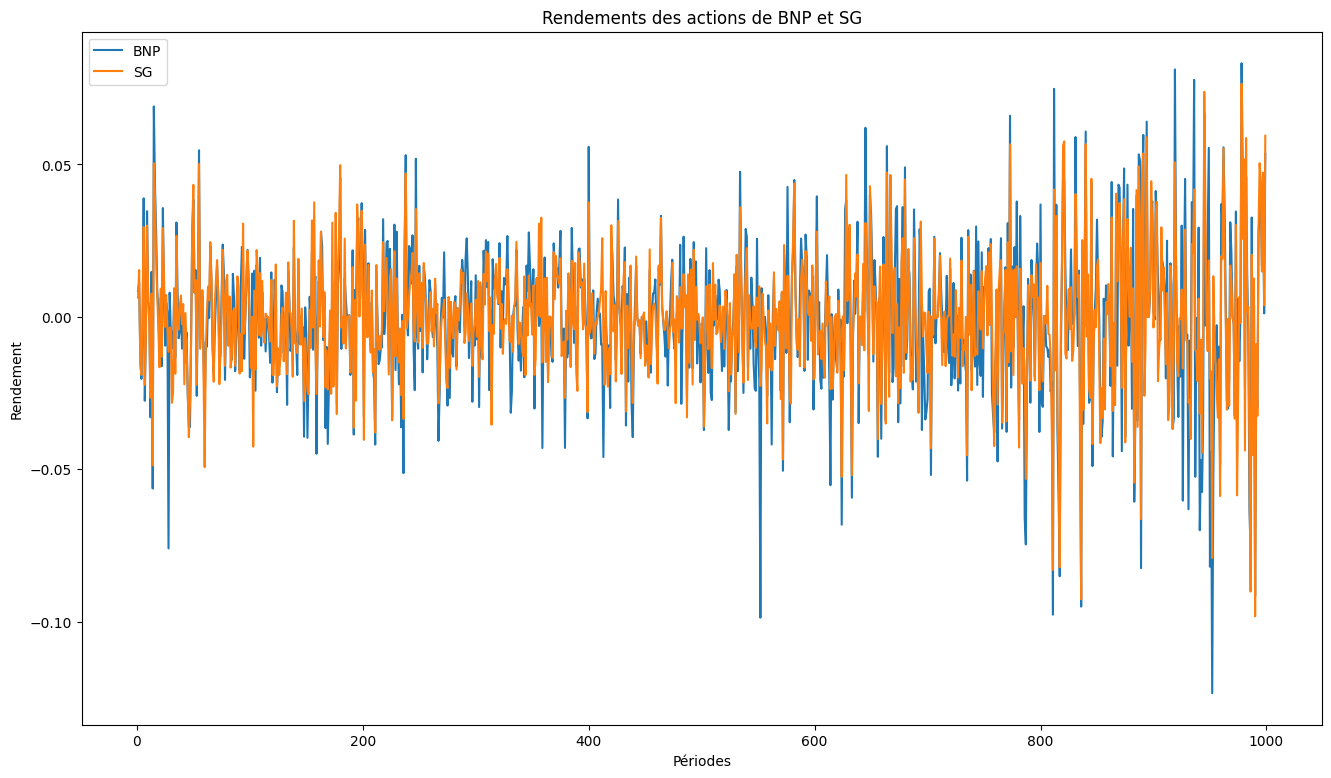

In [118]:
# Rendement(log) des actions des deux entreprises
stock = np.log(stock) - np.log(stock.shift())
stock.dropna(inplace=True)

stock.plot()

# Ajouter la légende et afficher le graphe
plt.legend()
plt.title("Rendements des actions de BNP et SG")
plt.xlabel("Périodes")
plt.ylabel("Rendement")

In [ ]:
# Resumé statistique des rendements des deux entreprises
stock.describe()

,BNP,SG
count,999.000000,999.000000
mean,-0.000888,-0.000687
std,0.024441,0.020731
min,-0.123524,-0.098292
25%,-0.013867,-0.011830
50%,-0.000358,-0.000547
75%,0.012526,0.011223
max,0.083225,0.076478


BNP et SG enregistrent des rendement moyens négatifs de l'ordre de $10^{-4}$ sur la période considérée, avec une volatilité de 2.44% pour BNP contre 2.07% pour SG. 

In [56]:
from skew_student import *
from scipy.stats import kstest, norm

In [57]:
param_bnp = optimize_parameters(stock["BNP"])
param_sg = optimize_parameters(stock["SG"])

In [58]:
mu, sigma, gamma, nu = param_bnp
sim_bnp = skew_student_sim(mu, sigma, gamma, nu, size = 100000)

mu, sigma, gamma, nu = param_sg
sim_sg = skew_student_sim(mu, sigma, gamma, nu, size = 100000)

In [59]:
def summary(df_observed, df_simulated):
        
        # Perform the KS test against a standard normal distribution
        ks_statistic, p_value = kstest(df_observed,df_simulated)
        print("KS Statistic:", ks_statistic)
        print("p-value:", p_value)
        
        """Generate a QQ plot comparing observed and simulated data."""
        quantiles_x = np.percentile(df_observed, np.linspace(0, 100, len(df_observed)))
        quantiles_y = np.percentile(df_simulated, np.linspace(0, 100, len(df_observed)))

        fig = plt.figure(figsize=(8, 6))
        plt.scatter(quantiles_x, quantiles_y, alpha=0.5)
        plt.plot([min(quantiles_x), max(quantiles_x)], [min(quantiles_x), max(quantiles_x)], color='red', linestyle='--')
        plt.title('QQ Plot Comparing Quantiles of Observed and Simulated Data')
        plt.xlabel('Empirical Quantiles')
        plt.ylabel('Theoretical Quantiles')
        plt.grid(True)
        plt.legend()
        
        
        

KS Statistic: 0.023846536536536567
p-value: 0.6184840120893087
KS Statistic: 0.02833555555555556
p-value: 0.3977699889635584


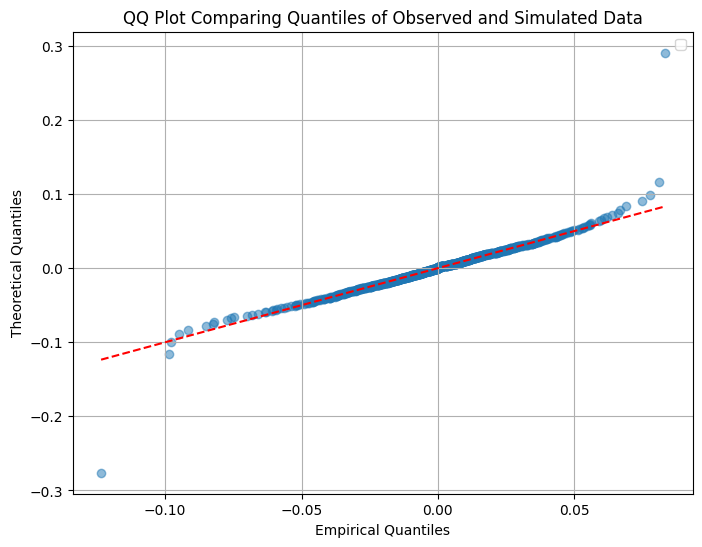

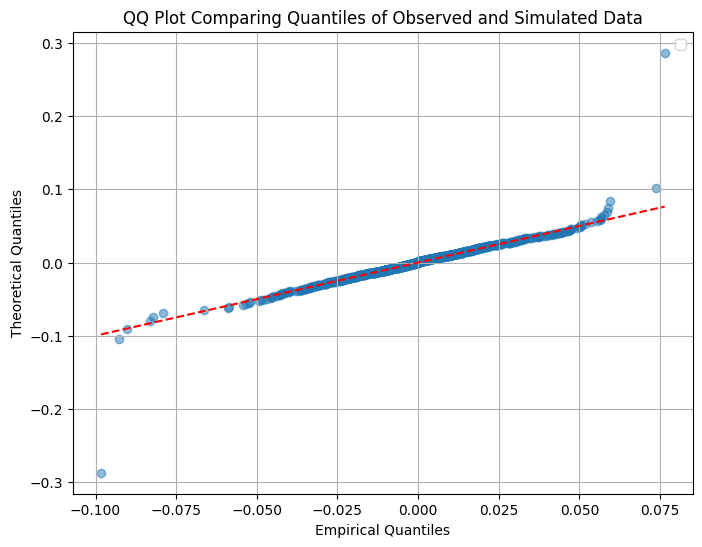

In [23]:
summary(stock["BNP"], sim_bnp)
summary(stock["SG"], sim_sg)

In [24]:
param_bnp

array([ 1.94963296e-03,  1.88612782e-02, -1.52042200e-01,  4.58745073e+00])

In [25]:
param_sg

array([-1.72713066e-03,  1.59158784e-02,  7.31422255e-02,  4.58450639e+00])

In [26]:
# Modélisation de la structure de dépendance 

In [25]:
# Transformation U = F_X(X)
def F_X(data):
    X_sorted = np.sort(data)
    F = np.array([np.sum(X_sorted<=x) for x in data]) / len(data)
    return F
    

In [26]:
U_bnp = F_X(stock["BNP"])
U_sg = F_X(stock["SG"])
U = np.array([U_bnp, U_sg]).T

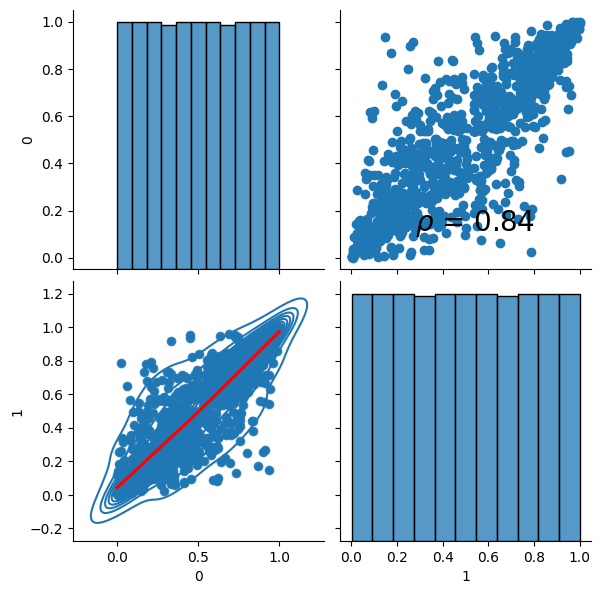

In [27]:
# Dépendogramme
plot(U)

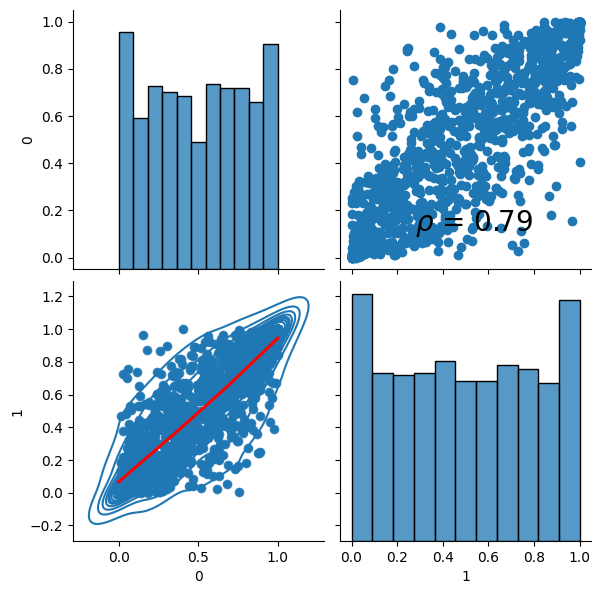

In [28]:
## Structure de dépendance gaussienne
df = 5
omega = np.corrcoef(U.T)
mean = np.array([0,0])
x = np.random.multivariate_normal(mean,omega,len(U))
chi_2 = np.random.chisquare(df=df,size=len(U)).reshape(-1, 1)
z = x/np.sqrt(chi_2/df)
z = norm.cdf(z, loc=0, scale =1)
plot(z)

In [29]:
from joblib import Parallel, delayed

def H(data, n_jobs=-1):
    """
    Compute the ECDF for each data point using parallel processing.

    Parameters:
        data (numpy.ndarray): A 2D array of shape (n, 2), where each row is a pair (X, Y).
        n_jobs (int): Number of jobs for parallel processing. Default is -1 (use all cores).

    Returns:
        numpy.ndarray: An array of ECDF values for each data point.
    """
    n = len(data)

    def compute_ecdf(i):
        X_excluded = np.delete(data[:, 0], i)
        Y_excluded = np.delete(data[:, 1], i)
        count = np.sum((X_excluded <= data[i, 0]) & (Y_excluded <= data[i, 1]))
        return count / (n - 1)

    # Use joblib for parallel processing
    F = Parallel(n_jobs=n_jobs)(delayed(compute_ecdf)(i) for i in range(n))
    return np.array(F)
    

In [30]:
H_emp = H(U)

In [31]:
def MC_H(df, omega, S = 100):
    ## Structure de dépendance gaussienne
    mean = np.array([0,0])
    H_s = []
    for s in range(S):
        x = np.random.multivariate_normal(mean,omega,len(U))
        chi_2 = np.random.chisquare(df=df,size=len(U)).reshape(-1, 1)
        z = x/np.sqrt(chi_2/df)
        H_s.append(H(norm.cdf(z, loc=0, scale =1)))
    H_s = np.array(H_s)
    return np.mean(H_s, axis=0)


In [256]:
H_theo = MC_H(3, omega)

ValueError: x and y must be the same size

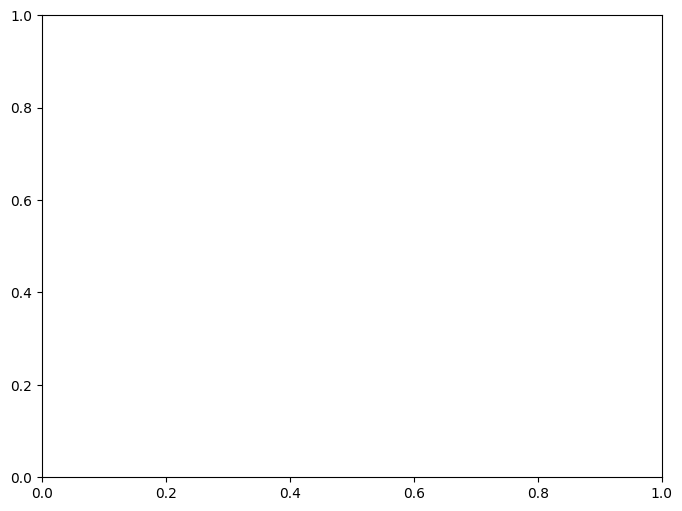

In [32]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(u, H_emp, alpha=0.5)
plt.plot([0,1], [0, 1], color='red', linestyle='--')
plt.title('Kendall Plot Comparing Quantiles of Observed and Simulated Data')
plt.xlabel('Empirical Quantiles')
plt.ylabel('Theoretical Quantiles')
plt.grid(True)
plt.legend()

# MOdelisation de la structure de dependance

In [19]:
# Identifying copula subclass from family of univariate copulas

# Fit GaussianMultivariate copula and estimate parameters
data = pd.DataFrame([stock["BNP"], stock["SG"]]).T
dist = GaussianMultivariate()
dist.fit(data)
parameters = dist.to_dict()

# print covariance matrix
print(
    "correlation : ",
    pd.DataFrame(
        parameters["correlation"],
        index=parameters["columns"],
        columns=parameters["columns"],
    ),
)

# print df/loc/scale parameters and copula subclass type
print(
    "- - - - - - - - - - - - - - -Parameters : \n",
    pd.DataFrame(parameters["univariates"], index=parameters["columns"]),
)

correlation :            BNP        SG
BNP  1.000000  0.860422
SG   0.860422  1.000000
- - - - - - - - - - - - - - -Parameters : 
                                                dataset  \
BNP  [0.008462673918733898, 0.01117330059812538, -0...   
SG   [0.006316000424286372, 0.015351961630293509, -...   

                                            type  
BNP  copulas.univariate.gaussian_kde.GaussianKDE  
SG   copulas.univariate.gaussian_kde.GaussianKDE  


In [20]:
# Fit student copula and estimate df and rho parameters
result = copulae.elliptical.gaussian.GaussianCopula().fit(
    data, method="ml"
)
print("- - - - - - - - - - - - - - -rho parameters : ", result.params)

              BNP          SG
count  999.000000  999.000000
mean     0.500000    0.500000
std      0.288527    0.288528
min      0.001000    0.001000
25%      0.250500    0.250500
50%      0.500000    0.500000
75%      0.749500    0.749500
max      0.999000    0.999000
- - - - - - - - - - - - - - -rho parameters :  [0.8609482]


In [87]:


# Obtain Transformed (pseudo observations) sample
var_bnp = pseudo_obs(stock["BNP"])
var_sg = pseudo_obs(stock["SG"])
data = pd.DataFrame([var_bnp, var_sg]).T
data.columns = ["var_bnp", "var_sg"]

# Obtain Simulated Data
result =  copulae.elliptical.student.StudentCopula(df=4).fit(
    data, method="ml", fix_df=True
)
u = result.random(len(stock), seed=12345)

# Kendal tau - original data
kendal_o = kendalltau(stock["BNP"], stock["SG"])
print("Kendal tau for original data")
print(
    "Kendall correlation : ",
    kendal_o.correlation,
    "Kendall p value     : ",
    kendal_o.pvalue,
)

# Kendal tau - synthesized sample
kendal_t = kendalltau(var_bnp, var_sg)
print("Kendal tau for synthesized sample")
print(
    "Kendall correlation : ",
    kendal_t.correlation,
    "Kendall p value     : ",
    kendal_t.pvalue,
)

# Kendal tau - simulated data
kendal_s = kendalltau(u.iloc[:, 0], u.iloc[:, 1])
print("Kendal tau for simulated data")
print(
    "Kendall correlation : ",
    kendal_s.correlation,
    "Kendall p value     : ",
    kendal_s.pvalue,
)

          var_bnp      var_sg
count  999.000000  999.000000
mean     0.500000    0.500000
std      0.288527    0.288528
min      0.001000    0.001000
25%      0.250500    0.250500
50%      0.500000    0.500000
75%      0.749500    0.749500
max      0.999000    0.999000
Kendal tau for original data
Kendall correlation :  0.6690959256638094 Kendall p value     :  9.880879953239367e-220
Kendal tau for synthesized sample
Kendall correlation :  0.6690959256638094 Kendall p value     :  9.880879953239367e-220
Kendal tau for simulated data
Kendall correlation :  0.6875913990142448 Kendall p value     :  2.717234539523453e-232


In [22]:
# GaussianCopula fitmetrics
gaus_cop = GaussianCopula().fit(
    pd.DataFrame([stock["BNP"], stock["SG"]]).T, method="ml"
)
gaus_cop_ll = gaus_cop.log_lik(pd.DataFrame([stock["BNP"], stock["SG"]]).T)
gaus_cop_gof = gof_copula(
    copula=GaussianCopula,
    data=pd.DataFrame([stock["BNP"], stock["SG"]]).T,
    reps=1,
)

print(gaus_cop)
print("The covariance parameters : ", gaus_cop.params)
print("The covariance matrix :", gaus_cop.sigma)
print("Log likelihood (LL) : ", gaus_cop_ll)
print("", gaus_cop_gof)

              BNP          SG
count  999.000000  999.000000
mean     0.500000    0.500000
std      0.288527    0.288528
min      0.001000    0.001000
25%      0.250500    0.250500
50%      0.500000    0.500000
75%      0.749500    0.749500
max      0.999000    0.999000
The covariance parameters :  [0.8609482]
The covariance matrix : [[1.        0.8609482]
 [0.8609482 1.       ]]
Log likelihood (LL) :  670.1417979216552
 Goodness-of-Fit statistics
Method     : Parametric bootstrap-based goodness-of-fit of Gaussian with Sn
Parameter  : [0.8609482]
Statistic  : 0.05459493
P-Value    : 0.25


In [88]:
# StudentCopula fitmetrics
st_cop = StudentCopula().fit(
    pd.DataFrame([stock["BNP"], stock["SG"]]).T, method="ml", fix_df=True
)
st_cop_ll = st_cop.log_lik(pd.DataFrame([stock["BNP"], stock["SG"]]).T)
# st_cop_gof = gof_copula(copula=StudentCopula, data=pd.DataFrame([data_set["DWJ"], data_set["10Y_TBY"]]).T, reps=1)

print(st_cop)
print("The covariance parameters : ", st_cop.params)
print("The covariance matrix :", st_cop.sigma)
print("Log likelihood (LL) : ", st_cop_ll)
# print('', st_cop_gof) ##Not implemented

              BNP          SG
count  999.000000  999.000000
mean     0.500000    0.500000
std      0.288527    0.288528
min      0.001000    0.001000
25%      0.250500    0.250500
50%      0.500000    0.500000
75%      0.749500    0.749500
max      0.999000    0.999000
The covariance parameters :  StudentParams(df=np.float64(4.669), rho=array([0.87419149]))
The covariance matrix : [[1.         0.87419149]
 [0.87419149 1.        ]]
Log likelihood (LL) :  720.8383282743333


In [40]:
# ClaytonCopula fitmetrics
cl_cop = ClaytonCopula().fit(
    pd.DataFrame([stock["BNP"], stock["SG"]]).T, method="ml"
)
cl_cop_ll = cl_cop.log_lik(pd.DataFrame([stock["BNP"], stock["SG"]]).T)
cl_cop_gof = gof_copula(
    copula=ClaytonCopula,
    data=pd.DataFrame([stock["BNP"], stock["SG"]]).T,
    reps=1,
)

print(cl_cop)
print("The covariance parameters : ", cl_cop.params)
# print('The covariance matrix :', cl_cop.sigma) ##Not implemented
print("Log likelihood (LL) : ", cl_cop_ll)
print("", cl_cop_gof)

              BNP          SG
count  999.000000  999.000000
mean     0.500000    0.500000
std      0.288527    0.288528
min      0.001000    0.001000
25%      0.250500    0.250500
50%      0.500000    0.500000
75%      0.749500    0.749500
max      0.999000    0.999000
The covariance parameters :  2.476781735562753
Log likelihood (LL) :  517.7235126512878
 Goodness-of-Fit statistics
Method     : Parametric bootstrap-based goodness-of-fit of Clayton with Sn
Parameter  : 2.476781735562753
Statistic  : 0.86480638
P-Value    : 0.75


In [41]:
# GumbelCopula fitmetrics
gumb_cop = GumbelCopula().fit(
    pd.DataFrame([stock["BNP"], stock["SG"]]).T, method="ml"
)
new_data = np.array(pd.DataFrame([stock["BNP"], stock["SG"]]).T)
gumb_cop_ll = gumb_cop.log_lik(new_data,to_pobs=True, ties='average')
gumb_cop_gof = gof_copula(
    copula=GumbelCopula,
    data=pd.DataFrame([stock["BNP"], stock["SG"]]).T,
    reps=1,
)

print(gumb_cop)
print("The covariance parameters : ", gumb_cop.params)
# print('The covariance matrix :', gumb_cop.sigma) ##Not implemented
print("Log likelihood (LL) : ", gumb_cop_ll)
print("", gumb_cop_gof)

              BNP          SG
count  999.000000  999.000000
mean     0.500000    0.500000
std      0.288527    0.288528
min      0.001000    0.001000
25%      0.250500    0.250500
50%      0.500000    0.500000
75%      0.749500    0.749500
max      0.999000    0.999000
The covariance parameters :  2.9939137019539217
Log likelihood (LL) :  703.1462793354614
 Goodness-of-Fit statistics
Method     : Parametric bootstrap-based goodness-of-fit of Gumbel with Sn
Parameter  : 2.9939137019539217
Statistic  : 0.034857264
P-Value    : 0.75


In [42]:
# FrankCopula fitmetrics
frank_cop = FrankCopula().fit(
    pd.DataFrame([stock["BNP"], stock["SG"]]).T, method="ml"
)
new_data = np.array(pd.DataFrame([stock["BNP"], stock["SG"]]).T)
frank_cop_ll = frank_cop.log_lik(new_data,to_pobs=True, ties='average')
frank_cop_gof = gof_copula(
    copula=FrankCopula,
    data=pd.DataFrame([stock["BNP"], stock["SG"]]).T,
    reps=1,
)

print(frank_cop)
print("The covariance parameters : ", frank_cop.params)
#print('The covariance matrix :', frank_cop.sigma) ##Not implemented
print("Log likelihood (LL) : ", frank_cop_ll)
print("", frank_cop_gof)

              BNP          SG
count  999.000000  999.000000
mean     0.500000    0.500000
std      0.288527    0.288528
min      0.001000    0.001000
25%      0.250500    0.250500
50%      0.500000    0.500000
75%      0.749500    0.749500
max      0.999000    0.999000
The covariance parameters :  10.127240819074121
Log likelihood (LL) :  630.2192493640814
 Goodness-of-Fit statistics
Method     : Parametric bootstrap-based goodness-of-fit of Frank with Sn
Parameter  : 10.127240819074121
Statistic  : 0.602916371
P-Value    : 0.75


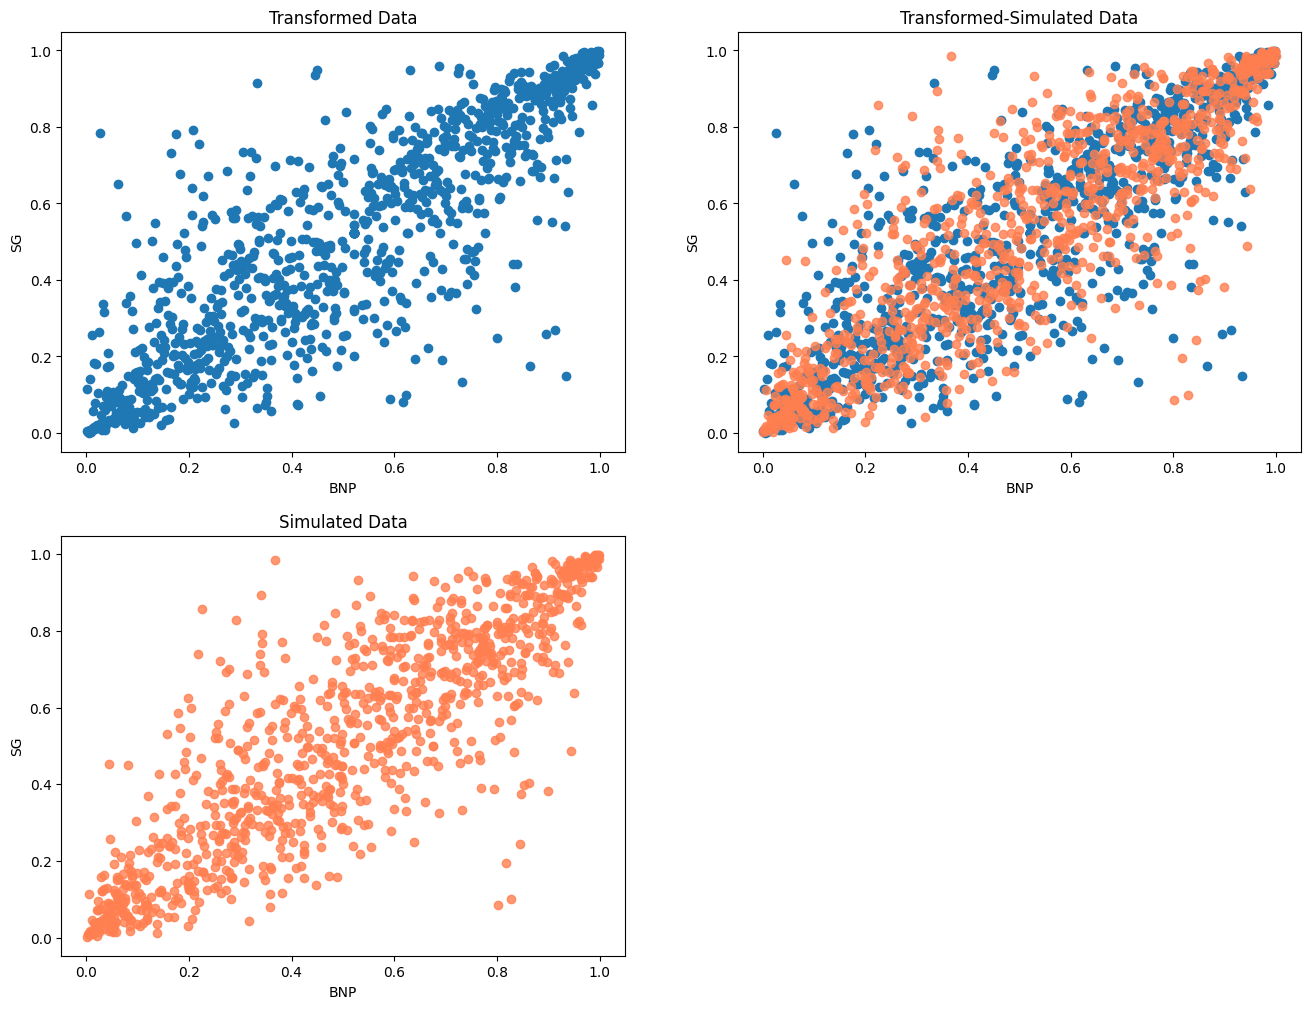

In [80]:
# Comparison of Transformed Observed Data and Simulated Data from Copula
plt.figure(figsize=(16, 12))

# Plot Transformed Data
ax1 = plt.subplot(221)
plt.scatter(data.var_bnp, data.var_sg)
plt.xlabel("BNP")
plt.ylabel("SG")
plt.title("Transformed Data")

# Plot Simulated Data
ax3 = plt.subplot(223)
plt.scatter(u.var_bnp, u.var_sg, c="coral", alpha=0.8)
plt.xlabel("BNP")
plt.ylabel("SG")
plt.title("Simulated Data")

# Plot Transformed-Simulated Data
ax2 = plt.subplot(222)
plt.scatter(data.var_bnp, data.var_sg)
plt.scatter(u.var_bnp, u.var_sg, c="coral", alpha=0.8)
plt.xlabel("BNP")
plt.ylabel("SG")
plt.title("Transformed-Simulated Data")
plt.show()

# Simulation des times to default

In [89]:
M = 1_000_0000
# Spread de maturité 4 ans
spread_bnp = 0.01
spread_sg = 0.012
EAD_bnp = 1000
EAD_sg = 1000


# Recouvrement
recovery_bnp = recovery_rate(mu = 0.6, sigma = 0.15, size=M)
recovery_sg = recovery_rate(mu = 0.3, sigma = 0.25, size=M)

# Structure de dépendance

# Obtain Transformed (pseudo observations) sample
var_bnp = pseudo_obs(stock["BNP"])
var_sg = pseudo_obs(stock["SG"])
data = pd.DataFrame([var_bnp, var_sg]).T
data.columns = ["var_bnp", "var_sg"]

# Obtain Simulated Data
result = copulae.elliptical.student.StudentCopula().fit(
    data, method="ml", fix_df = True
)
u = result.random(M) # seed=12345

# Défaut
tau_bnp = -np.log(1-u.var_bnp)/spread_bnp
tau_sg = -np.log(1-u.var_sg)/spread_sg

default_bnp = (tau_bnp<=4).astype(int)
default_sg = (tau_sg<=4).astype(int)

# Loss function
L = EAD_bnp*(1-recovery_bnp)*default_bnp + EAD_sg*(1-recovery_sg)*default_sg

          var_bnp      var_sg
count  999.000000  999.000000
mean     0.500000    0.500000
std      0.288527    0.288528
min      0.001000    0.001000
25%      0.250500    0.250500
50%      0.500000    0.500000
75%      0.749500    0.749500
max      0.999000    0.999000


In [99]:
# CVAR
L.quantile(0.99)

np.float64(1233.734380846697)

In [91]:
print(np.mean(default_bnp))
print(np.mean(default_sg))

0.0393211
0.0469676


In [ ]:
from scipy.stats import gaussian_kde
from copulae import EmpiricalCopula, GaussianCopula, StudentCopula, FrankCopula, GumbelCopula

def blanket_test_statistic(copula, empirical_copula, grid_points):
    """
    Calcule la statistique de test intégrale sur [0,1]^2
    """
    theoretical = copula.cdf(grid_points)
    empirical = empirical_copula.cdf(grid_points)
    return np.mean((theoretical - empirical)**2)

def bootstrap_pvalue(copula_model, data, emp_copula, n_boot=1000):
    """
    Procédure bootstrap paramétrique pour calculer la p-valeur
    """
    # Calcul de la statistique observée
    grid = np.random.rand(500, 2)  # Points aléatoires pour l'intégration
    obs_stat = blanket_test_statistic(copula_model, emp_copula, grid)
   
    # Génération bootstrap sous H0
    boot_stats = []
    for _ in range(n_boot):
        # Simulation depuis la copule théorique
        sim_data = copula_model.random(len(data))
       
        # Ajustement de la copule aux données simulées
        boot_copula = copula_model.__class__(dim=2)
        boot_copula.fit(sim_data)
       
        # Calcul de la statistique
        ec = EmpiricalCopula(sim_data)
        stat = blanket_test_statistic(boot_copula, ec, grid)
        boot_stats.append(stat)
   
    # Calcul de la p-valeur
    return np.mean(np.array(boot_stats) >= obs_stat)

# Préparation des données
rank_data = stock[["BNP","SG"]].rank() / (len(stock) + 1)
emp_copula = EmpiricalCopula(rank_data.values)  # Copule empirique

# Configuration des tests
copula_models = {
    "Gaussian": GaussianCopula(2),
    "Student-t": StudentCopula(df=2),
    "Gumbel": GumbelCopula(2),
    "Frank": FrankCopula(2)
}

# Exécution des tests
results = []
for name, model in copula_models.items():
    try:
        if name == "Student-t":
            model.fit(rank_data.values, fix_df = True, method = "ml")
            pvalue = bootstrap_pvalue(model, rank_data.values, emp_copula, n_boot=100)
        else:
            model.fit(rank_data.values, method="ml")
            pvalue = bootstrap_pvalue(model, rank_data.values, emp_copula, n_boot=100)

        results.append({
            "Copula": name,
            "Statistique": blanket_test_statistic(model, emp_copula, np.random.rand(1000, 2)),
            "p-value": pvalue
        })
    except Exception as e:
        print(f"Erreur avec {name}: {str(e)}")
        results.append({"Copula": name, "Erreur": str(e)})

# Affichage des résultats
results_df = pd.DataFrame(results)
print("\nRésultats des tests d'adéquation:")
print(results_df.set_index("Copula"))


              BNP          SG
count  999.000000  999.000000
mean     0.500000    0.500000
std      0.288527    0.288528
min      0.001000    0.001000
25%      0.250500    0.250500
50%      0.500000    0.500000
75%      0.749500    0.749500
max      0.999000    0.999000
Erreur avec Student-t: 

Résultats des tests d'adéquation:
           Statistique  p-value Erreur
Copula                                
Gaussian      0.000019     0.00    NaN
Student-t          NaN      NaN       
Gumbel        0.000013     0.02    NaN
Frank         0.001644     0.16    NaN


In [107]:
model  = StudentCopula().fit(
    pd.DataFrame([stock["BNP"], stock["SG"]]).T, method="ml", fix_df=True
)
pvalue = bootstrap_pvalue(model, rank_data.values, emp_copula, n_boot=100)

              BNP          SG
count  999.000000  999.000000
mean     0.500000    0.500000
std      0.288527    0.288528
min      0.001000    0.001000
25%      0.250500    0.250500
50%      0.500000    0.500000
75%      0.749500    0.749500
max      0.999000    0.999000


NotImplementedError: 